# END-TO-END IMPACT CALCULATION

#### Goal of this tutorial

The goal of this tutorial is to show a full end-to-end impact computation. Note that this tutorial examplifies the work flow, but does not explore all possible features.

#### What is an Impact?

The impact is the combined effect of hazard events on a set of exposures mediated by a set of impact functions. By computing the impact for each event (historical and synthetic) and for each exposure value at each geographical location, the Impact class provides different risk measures, such as the expected annual impact per exposure, the probable maximum impact for different return periods, and the total average annual impact.

#### Impact class data structure

The impact class does not require any attributes to be defined by the user. All attributes are set by the method `impact.calc()`. This method requires three attributes: an `Exposure`, a `Hazard`, and an `ImpactFuncSet`. After calling `impact.calc(Exposure, ImpactFuncSet, Hazard, save_mat=False)`, the Impact object has the following attributes:

| Attributes from input | Data Type | Description|
| :- | :- | :- |
| tag |(dict)| dictionary storing the tags of the inputs (Exposure.tag, ImpactFuncSet.tag Hazard.tag)|
| even_id |list(int)| id (>0) of each hazard event (Hazard.event_id) |
| event_name |(list(str))| name of each event (Hazard.event_name)|
| date |np.array| date of events (Hazard.date)|
| coord_exp |np.array| exposures coordinates [lat, lon] (in degrees) (Exposure.gdf.latidues, Exposure.gdf.longitude)|
| frequency |np.array| annual frequency of events (Hazard.frequency)|
| unit |str| value unit used (Exposure.value_unit)|
| csr |str| unit system for Exposure and Hazard geographical data (Exposure.csr)|

<br>
<br>

| Computed attributes | Data Type | Description|
| :- | :- | :- |
| at_event |np.array| impact for each hazard event summed over all locations |
| eai_exp |np.array| expected annual impact for each locations, summed over all events weigthed by frequency |
| aai_agg |float| total annual average aggregated impact value (summed over events and locations) |
| impt_mat |sparse.csr_matrix| matrix (num_events X num_exp) with impact values (only filled if save_mat is True). |
| tot_value |float| total exposure value affected (sum of value all exposures locations affected by at least one hazard event) |

All other methods compute values from the attributes set by `Impact.cacl()`. For example, one can compute the frequency exceedance curve, plot impact data, or compute traditional risk transfer over impact.

#### How do I compute an impact in CLIMADA?

In CLIMADA, impacts are computed using the `Impact` class. To computation of the impact requires an `Exposure` , an `ImpactFuncSet`, and a `Hazard` object. For details about how to define __[Exposures](climada_entity_Exposures.ipynb)__ , __[Hazard](climada_hazard_Hazard.ipynb)__, __[Impact Functions](climada_entity_ImpactFuncSet.ipynb)__ see the respective tutorials.

The steps of an impact caculations are typically:

- Set exposure
- Set hazard and hazard centroids
- Set impact functions in impact function set
- Compute impact
- Visualize, save, use impact output



Hints:
Before computing the impact of a given `Exposure` and `Hazard`, it is important to correctly match the `Exposures'` coordinates with the `Hazard` `Centroids`. Try to have similar resolutions in `Exposures` and `Hazard`. By the impact calculation the nearest neighbor for each `Exposure` to the `Hazard's` `Centroids` is searched. 

Hint: 
Set first the `Exposures` and use its coordinates information to set a matching `Hazard`.

Hint:
The configurable parameter `max_matrix_size` defined in the __[configuration file](../../climada/conf/defaults.conf)__ (located at `/climada/conf/defaults.conf`) controls the maximum matrix size contained in a chunk. You can decrease its value if you are having memory issues when using the `Impact.calc()` method. A high value will make the computation fast, but increase the memory use. 

#### Structure of the tutorial 

We begin with one very detailled example, and later present in quick and dirty examples.

__[Part1](#part1)__: Detailed impact calculation with Litpop and TropCyclone

__[Part2](#part2)__: Quick examples: raster and point exposures/hazards

__[Part3](#part3)__: Visualization methods

## Detailed Impact calculation - LitPop + TropCyclone
<a id='part1'></a> 

We present a detailed example for the hazard __[Tropical Cyclones](climada_hazard_TropCyclone.ipynb)__ and the exposures from __[LitPop](climada_entity_LitPop.ipynb)__ .

### Define the exposure

Reminder: The exposures must be defined according to your problem either using CLIMADA exposures such as __[BlackMarble](climada_entity_BlackMarble.ipynb)__, __[LitPop](climada_entity_LitPop.ipynb), [OSM](climada_entity_openstreetmap.ipynb)__, extracted from external sources (imported via csv, excel, api, ...) or directly user defined. As a reminder, exposures  are geopandas dataframes with at least columns 'latitude', 'longitude' and 'value' of exposures. For impact calculations, for each exposure value the corresponding impact function to use (defined by the column impf_) and the associated hazard centroids must be defined. This is done after defining the impact function(s) and the hazard(s). See tutorials on __[Exposures](climada_entity_Exposures.ipynb)__ , __[Hazard](climada_hazard_Hazard.ipynb)__, __[ImpactFuncSet](climada_entity_ImpactFuncSet.ipynb)__ for more details.

Exposures are either defined as a series of (latitude/longitude) points or as a raster of (latitude/longitude) points. Fundamentally, this changes nothing for the impact computations. Note that for larger number of points, consider using a raster which might be more efficient (computationally). For a low number of points, avoid using a raster if this adds a lot of exposures values equal to 0. 

We shall here use a raster example.

In [1]:
# Exposure from the module Litpop 
# Note that the file gpw_v4_population_count_rev11_2015_30_sec.tif must be downloaded (do not forget to unzip) if
# you want to execute this cell on your computer.

%matplotlib inline
import numpy as np
from climada.entity import LitPop

# Cuba with resolution 10km and financial_mode = income group.
exp_lp = LitPop()
exp_lp.set_country(countries=['CUB'], res_km=10, fin_mode='income_group')
exp_lp.check()

2021-04-23 14:28:05,542 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-04-23 14:28:05,543 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-04-23 14:28:05,543 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-04-23 14:28:05,544 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-04-23 14:28:05,545 - climada.entity.exposures.base - INFO - crs set to default value: EPSG:4326


/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:221: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf.crs = self.meta['crs']


2021-04-23 14:28:06,725 - climada.entity.exposures.litpop - INFO - Generating LitPop data at a resolution of 300.0 arcsec.
2021-04-23 14:28:09,609 - climada.entity.exposures.gpw_import - INFO - Reference year: 2016. Using nearest available year for GPW population data: 2015
2021-04-23 14:28:09,610 - climada.entity.exposures.gpw_import - INFO - GPW Version v4.11
2021-04-23 14:28:23,056 - climada.util.finance - INFO - GDP CUB 2016: 9.137e+10.
2021-04-23 14:28:23,119 - climada.util.finance - INFO - Income group CUB 2016: 3.
2021-04-23 14:28:23,297 - climada.entity.exposures.base - INFO - meta set to default value {}
2021-04-23 14:28:23,298 - climada.entity.exposures.base - INFO - tag set to default value  File: 
 Description: 
2021-04-23 14:28:23,298 - climada.entity.exposures.base - INFO - ref_year set to default value 2018
2021-04-23 14:28:23,299 - climada.entity.exposures.base - INFO - value_unit set to default value USD
2021-04-23 14:28:23,300 - climada.entity.exposures.base - INFO - 

/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:221: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  self.gdf.crs = self.meta['crs']
/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:725: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  exp.gdf = GeoDataFrame(
/Users/zeliestalhanske/miniconda3/envs/climada_env/lib/python3.8/site-packages/geopandas/geodataframe.py:167: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)
/Users/zeliestalhanske/python_projects/climada_python/climada/entity/exposures/base.py:190: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is 

In [2]:
exp_lp.gdf.head()

,value,latitude,longitude,region_id,impf_
0,9.818338e+05,21.875000,-84.875000,192,1
1,1.110009e+06,21.875000,-84.791667,192,1
2,0.000000e+00,21.958333,-84.708333,192,1
3,1.026952e+06,21.958333,-84.625000,192,1
4,1.109359e+06,21.958333,-84.541667,192,1


2021-04-23 14:28:23,369 - climada.util.coordinates - INFO - Raster from resolution 0.0833333333333286 to 0.0833333333333286.

 Raster properties exposures: {'width': 129, 'height': 41, 'crs': 'EPSG:4326', 'transform': Affine(0.0833333333333286, 0.0, -84.91666666666669,
       0.0, 0.0833333333333286, 19.833333333333336)}


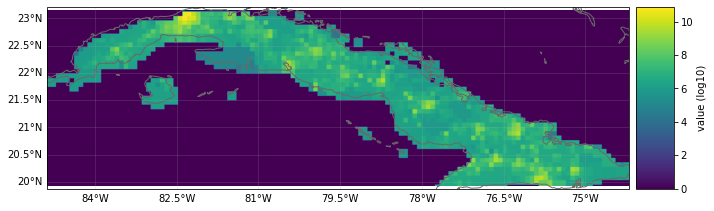

In [3]:
# not needed for impact calculations
# visualize the define exposure
exp_lp.plot_raster()
print('\n Raster properties exposures:', exp_lp.meta)

### Define the hazard 

Let us define a tropical cyclone hazard using the TropCyclone and TCTracks modules. 

In [ ]:
from climada.hazard import TCTracks, TropCyclone, Centroids

# Load histrocial tropical cyclone tracks from ibtracs over the North Atlantic basin between 2010-2012
ibtracks_na = TCTracks()
ibtracks_na.read_ibtracs_netcdf(provider='usa', basin='NA', year_range=(2010, 2012), correct_pres=True)
print('num tracks hist:', ibtracks_na.size)
#Add randomly generated tracks using the calc_random_walk method (2 per historical track)
ibtracks_na.calc_random_walk(ens_size=1)
print('num tracks hist+syn:', ibtracks_na.size)
ibtracks_na.equal_timestep(0.5)  # Interpolation to make the track smooth c.f.

In [ ]:
# not needed for calculations
# visualize tracks
ax = ibtracks_na.plot()
ax.get_legend()._loc = 2

From the tracks, we generate the hazards (the tracks are only the coordinates of the center of the cyclones, the full cyclones however affects a region around the tracks). 

First thing we define the set of centroids which are geographical points where the hazard has a defined value. In our case, we want to define windspeeds from the tracks.

Remember:
In the impact computations, for each exposure geographical point, one must assign a centroid from the hazard. By default, each exposure is assigned to the closest centroid from the hazard. But one can also define manually which centroid is assigned to which exposure point.

Examples: 
- Define the exposures from a given source (e.g., raster of asset values from LitPop). Define the hazard centroids from the exposures' geolocations (e.g. compute Tropical Cyclone windspeed at each raster point and assign centroid to each raster point).
- Define the exposures from a given source (e.g. houses position and value). Define the hazard from a given source (e.g. where lanslides occur). Use a metric to assign to each exposures point a hazard centroid (all houses in a radius of 5km around the lanslide are assigned to this centroid, if a house is within 5km of two landslides, choose the closest one). 
- Define a geographical raster. Define the exposures value on this raster. Define the hazard centroids on the geographical raster.

We shall pursue with the first case (Litpop + TropicalCyclone)

Hint: computing the wind speeds in many locations for many tc tracks is a computationally costly operation. Thus, we should define centroids only where we also have an exposure.

In [ ]:
# Define the centroids from the exposures position
centrs = Centroids()
lat = exp_lp.gdf['latitude'].values
lon = exp_lp.gdf['longitude'].values
centrs.set_lat_lon(lat, lon)
centrs.check()

In [ ]:
# Using the tracks, compute the windspeed at the location of the centroids
tc = TropCyclone()
tc.set_from_tracks(ibtracks_na, centrs)
tc.check()

Hint: The operation of computing the windspeed in different location is in general computationally expensive. Hence, if you have a lot of tropical cyclone tracks, you should first make sure that all your tropical cyclones actually affect your exposure (remove those that don't). Then, be careful when defining the centroids. For a large country like  China, there is no need for centroids 500km inlans (no tropical cyclones gets so far).

### Impact function 

For Tropical Cyclones, some calibrated default impact functions exist. Here we will use the one from Emanuel (2011).

In [ ]:
from climada.entity import ImpactFuncSet, IFTropCyclone
# impact function TC
impf_tc= IFTropCyclone()
impf_tc.set_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet()
impf_set.append(impf_tc)
impf_set.check()

Recall that the exposures, hazards and impact functions  must be matched in the impact calculations. Here it is simple, since there is a single impact function for all the hazards. We must simply make sure that the exposure is assigned this impact function through renaming the `impf_` column from the hazard type of the impact function in the impact function set and set the values of the column to the id of the impact function. 

In [ ]:
# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
print(f"hazard type: {haz_type}, hazard id: {haz_id}")

In [ ]:
# Exposures: rename column and assign id
exp_lp.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
exp_lp.gdf['impf_' + haz_type] = haz_id
exp_lp.check()
exp_lp.gdf.head()

### Impact computation 

We are finally ready for the impact computation. This is the simplest step. Just give the exposure, impact function and hazard to the Impact.calc() method.

Note: we did not specifically assign centroids to the exposures. Hence, the default is used - each exposure is associated with the closest centroids. Since we defined the centroids from the exposures, this is a one-to-one mapping.

Note: we did not define an `Entity`  in this impact calculations. Recall that `Entity` is a container class for __[Exposures](climada_entity_Exposures.ipynb)__, __[Impact Functions](climada_entity_ImpactFuncSet.ipynb)__, __[Discount Rates](climada_entity_DiscRates.ipynb)__ and __[Measures](climada_entity_MeasureSet.ipynb)__. Since we had only one Exposure and one Impact Function, the container would not have added any value, but for more complex projects, the Entity class is very useful.

In [ ]:
# Compute impact
from climada.engine import Impact
imp = Impact()
imp.calc(exp_lp, impf_set, tc, save_mat=False) #Do not save the results geographically resolved (only aggregate values)

In [ ]:
exp_lp.gdf

For example we can now obtain the aggregated average annual impact or plot the average annual impact in each exposure location.

In [ ]:
print(f"Aggregated average annual impact: {round(imp.aai_agg,0)} $")

In [ ]:
imp.plot_hexbin_eai_exposure(buffer=1)

In [ ]:
# Compute exceedance frequency curve
freq_curve = imp.calc_freq_curve()
freq_curve.plot()

## Quick examples - points, raster, custom
<a id='part2'></a> 

### User defined point exposure and Tropical Cyclone hazard

In [ ]:
%matplotlib inline
# EXAMPLE: POINT EXPOSURES WITH POINT HAZARD
import numpy as np
from climada.entity import Exposures, ImpactFuncSet, IFTropCyclone
from climada.hazard import Centroids, TCTracks, TropCyclone
from climada.engine import Impact

# Set Exposures in points
exp_pnt = Exposures(crs='epsg:4326') #set coordinate system
exp_pnt['latitude'] = np.array([21.899326, 21.960728, 22.220574, 22.298390, 21.787977, 21.787977, 21.981732])
exp_pnt['longitude'] = np.array([88.307422, 88.565362, 88.378337, 87.806356, 88.348835, 88.348835, 89.246521])
exp_pnt['value'] = np.array([1.0e5, 1.2e5, 1.1e5, 1.1e5, 2.0e5, 2.5e5, 0.5e5])
exp_pnt.check()
exp_pnt.plot_scatter(buffer=0.05)

# Set Hazard in Exposures points
# set centroids from exposures coordinates
centr_pnt = Centroids()
centr_pnt.set_lat_lon(exp_pnt.latitude.values, exp_pnt.longitude.values, exp_pnt.crs)
# compute Hazard in that centroids
tr_pnt = TCTracks()
tr_pnt.read_ibtracs_netcdf(storm_id='2007314N10093')
tc_pnt = TropCyclone()
tc_pnt.set_from_tracks(tr_pnt, centroids=centr_pnt)
tc_pnt.check()
ax_pnt = tc_pnt.centroids.plot(c=np.array(tc_pnt.intensity[0,:].todense()).squeeze()) # plot intensity per point
ax_pnt.get_figure().colorbar(ax_pnt.collections[0], fraction=0.0175, pad=0.02).set_label('Intensity (m/s)') # add colorbar

# Set impact function
impf_pnt = ImpactFuncSet()
impf_tc = IFTropCyclone()
impf_tc.set_emanuel_usa()
impf_pnt.append(impf_tc)
impf_pnt.check()

# Get the hazard type and hazard id
[haz_type] = impf_set.get_hazard_types()
[haz_id] = impf_set.get_ids()[haz_type]
# Exposures: rename column and assign id
exp_lp.gdf.rename(columns={"impf_": "impf_" + haz_type}, inplace=True)
exp_lp.gdf['impf_' + haz_type] = haz_id
exp_lp.gdf.head()

# Compute Impact
imp_pnt = Impact()
imp_pnt.calc(exp_pnt, impf_pnt, tc_pnt)
# nearest neighbor of exposures to centroids gives identity
print('Nearest neighbor hazard.centroids indexes for each exposure:', exp_pnt.centr_TC.values)
imp_pnt.plot_scatter_eai_exposure(ignore_zero=False, buffer=0.05)

### Raster from file 

In [ ]:
# EXAMPLE: RASTER EXPOSURES WITH RASTER HAZARD
from rasterio.warp import Resampling
from climada.entity import LitPop, ImpactFuncSet, ImpactFunc
from climada.hazard import Hazard
from climada.engine import Impact
from climada.util.constants import HAZ_DEMO_FL

# Exposures belonging to a raster (the raser information is contained in the meta attribute)
exp_ras = LitPop()
exp_ras.set_country(countries=['VEN'], res_km=10, fin_mode='income_group')
exp_ras.reset_index()
exp_ras.check()
exp_ras.plot_raster()
print('\n Raster properties exposures:', exp_ras.meta)

# Initialize hazard object with haz_type = 'FL' (for Flood)
hazard_type='FL'
haz_ras = Hazard(haz_type=hazard_type)
# Load a previously generated (either with CLIMADA or other means) hazard 
# from file (HAZ_DEMO_FL) and resample the hazard raster to the exposures' ones
# Hint: check how other resampling methods affect to final impact
haz_ras.set_raster([HAZ_DEMO_FL], dst_crs=exp_ras.meta['crs'], transform=exp_ras.meta['transform'],
                   width=exp_ras.meta['width'], height=exp_ras.meta['height'],
                   resampling=Resampling.nearest)
haz_ras.intensity[haz_ras.intensity==-9999] = 0 # correct no data values
haz_ras.check()
haz_ras.plot_intensity(1)
print('Raster properties centroids:', haz_ras.centroids.meta)

# Set dummy impact function
impf_dum = ImpactFunc()
impf_dum.id = haz_id
impf_dum.name = 'dummy'
impf_dum.intensity_unit = 'm'
impf_dum.haz_type = hazard_type
impf_dum.intensity = np.linspace(0, 10, 100)
impf_dum.mdd = np.linspace(0, 10, 100)
impf_dum.paa = np.ones(impf_dum.intensity.size)
# Add the impact function to the impact function set
impf_ras = ImpactFuncSet()
impf_ras.append(impf_dum)
impf_ras.check()

# Exposures: rename column and assign id
exp_lp.gdf.rename(columns={"impf_": "impf_" + hazard_type}, inplace=True)
exp_lp.gdf['impf_' + haz_type] = haz_id
exp_lp.gdf.head()

# Compute impact
imp_ras = Impact()
imp_ras.calc(exp_ras, impf_ras, haz_ras, save_mat=False)
# nearest neighbor of exposures to centroids is not identity because litpop does not contain data outside the country polygon
print('\n Nearest neighbor hazard.centroids indexes for each exposure:', exp_ras.centr_FL.values)
imp_ras.plot_raster_eai_exposure()

## VISUALIZATION
<a id='part3'></a> 

### Making plots 

The expected annual impact per exposure can be visualized through different methods: `plot_hexbin_eai_exposure()`, `plot_scatter_eai_exposur()`, `plot_raster_eai_exposure()` and `plot_basemap_eai_exposure()` (similarly as with  `Exposures`).

In [ ]:
imp_pnt.plot_basemap_eai_exposure(buffer=5000)

### Making videos

Given a fixed exposure and impact functions, a sequence of hazards can be visualized hitting the exposures.

In [ ]:
# exposure
from climada.entity import BlackMarble, add_sea
country_name = {'United States Of America': ['Florida']}
exp_video = BlackMarble()
exp_video.set_countries(country_name, 2016, res_km=2.5)
exp_video.check()

# impact function
impf_def = IFTropCyclone()
impf_def.set_emanuel_usa()
impfs_video = ImpactFuncSet()
impfs_video.append(impf_def)
impfs_video.check()

# compute sequence of hazards using TropCyclone video_intensity method
exp_sea = add_sea(exp_video, (100, 5))
centr_video = Centroids()
centr_video.set_lat_lon(exp_sea.latitude.values, exp_sea.longitude.values)
centr_video.check()

track_name = '2017242N16333' 
tr_irma = TCTracks()
tr_irma.read_ibtracs_netcdf(provider='usa', storm_id=track_name) # IRMA 2017

tc_video = TropCyclone()
tc_list, _ = tc_video.video_intensity(track_name, tr_irma, centr_video) # empty file name to not to write the video

# generate video of impacts
file_name='./results/irma_imp_fl.gif'
imp_video = Impact()
imp_list = imp_video.video_direct_impact(exp_video, impfs_video, tc_list, file_name)
